Generating 7x7 Grid Visualization...
7x7 grid plot saved to plots/grid_7x7.png


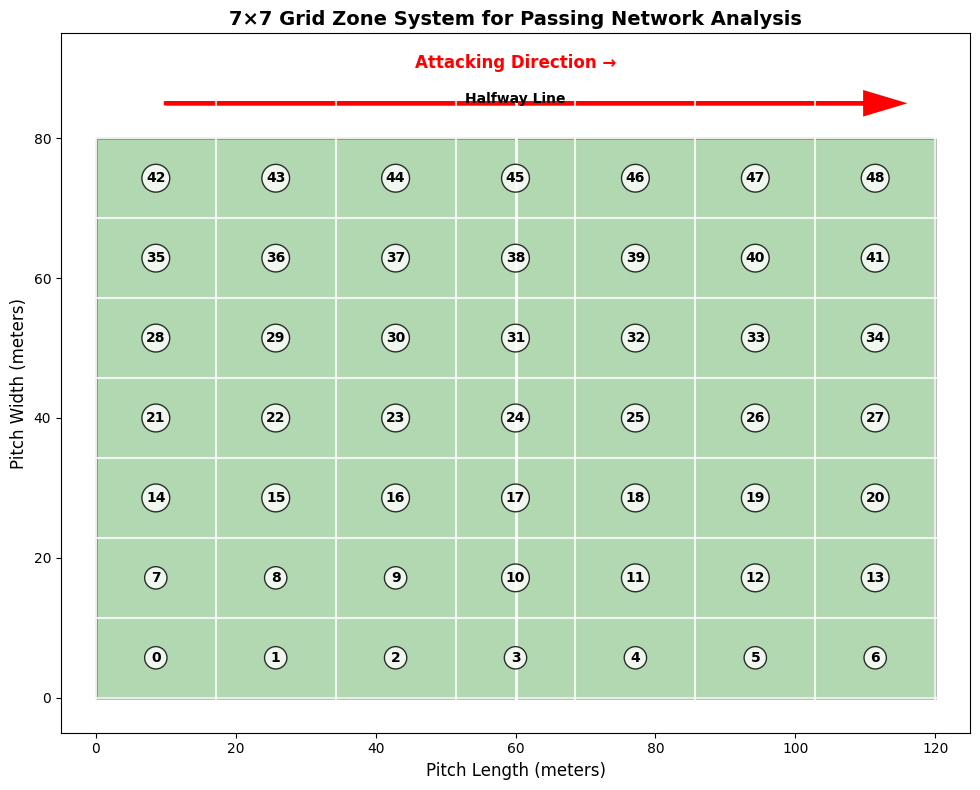


Generating Adjacency Matrix Visualization...
Adjacency matrix plot saved to plots/adjacency_matrix_3754058.png


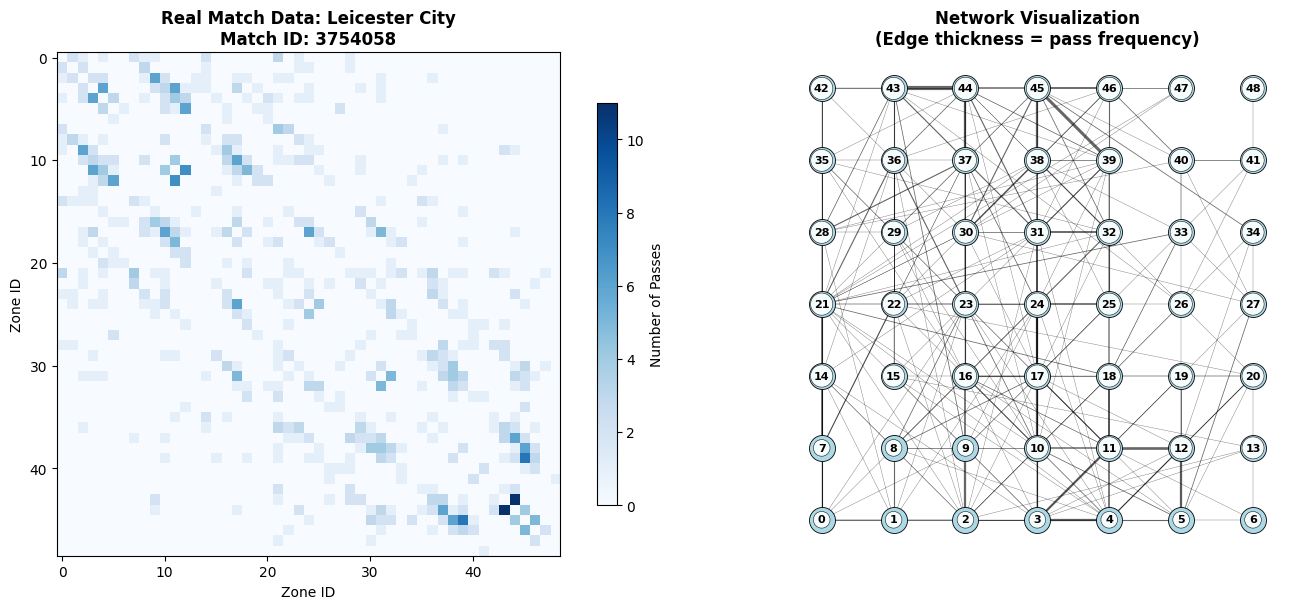

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
import os

def plot_7x7_grid(output_dir="."):
    """Plot the 7x7 grid overlay on football pitch and save it"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Draw pitch outline
    pitch = patches.Rectangle((0, 0), 120, 80, linewidth=2, 
                             edgecolor='black', facecolor='green', alpha=0.3)
    ax.add_patch(pitch)
    
    # Draw 7x7 grid
    for i in range(8):  # 8 lines for 7 zones
        x = i * (120/7)
        ax.axvline(x, color='white', linewidth=1.5, alpha=0.8)
        y = i * (80/7)
        ax.axhline(y, color='white', linewidth=1.5, alpha=0.8)
    
    # Add zone numbers
    for row in range(7):
        for col in range(7):
            zone_id = row * 7 + col
            x_center = (col + 0.5) * (120/7)
            y_center = (row + 0.5) * (80/7)
            ax.text(x_center, y_center, str(zone_id), 
                   ha='center', va='center', fontsize=10, 
                   fontweight='bold', color='black',
                   bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
    
    # Halfway line and arrow
    ax.axvline(60, color='white', linewidth=2)
    ax.text(60, 85, 'Halfway Line', ha='center', fontweight='bold')
    ax.arrow(10, 85, 100, 0, head_width=3, head_length=5, fc='red', ec='red', linewidth=3)
    ax.text(60, 90, 'Attacking Direction →', ha='center', fontweight='bold', color='red', fontsize=12)
    
    ax.set_xlim(-5, 125)
    ax.set_ylim(-5, 95)
    ax.set_xlabel('Pitch Length (meters)', fontsize=12)
    ax.set_ylabel('Pitch Width (meters)', fontsize=12)
    ax.set_title('7×7 Grid Zone System for Passing Network Analysis', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, "grid_7x7.png")
    fig.savefig(save_path, dpi=300)
    print(f"7x7 grid plot saved to {save_path}")
    
    plt.show()


def plot_adjacency_matrix_from_real_data(json_file="/workspaces/masters-thesis/statsbomb_data_interim_100.json", 
                                        match_id=None, team_name=None, output_dir="."):
    """Plot adjacency matrix using real match data and save it"""
    import json
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    if match_id is None:
        match_id = list(data['events'].keys())[0]
    events = data['events'][match_id]
    df = pd.DataFrame(events)
    
    if team_name is None:
        team_name = df['team'].value_counts().index[0]
    
    passes = df[(df['type'] == 'Pass') & (df['team'] == team_name)].copy()
    
    def extract_zone(location, period):
        if not location or len(location) < 2:
            return None
        x, y = location[0], location[1]
        if period == 2:
            x = 120 - x
            y = 80 - y
        x_norm = max(0, min(1, x / 120))
        y_norm = max(0, min(1, y / 80))
        zone_x = min(6, int(x_norm * 7))
        zone_y = min(6, int(y_norm * 7))
        return zone_y * 7 + zone_x
    
    passes['origin_zone'] = passes.apply(lambda row: extract_zone(row.get('location'), row.get('period')), axis=1)
    passes['dest_zone'] = passes.apply(lambda row: extract_zone(row.get('pass_end_location'), row.get('period')), axis=1)
    passes = passes.dropna(subset=['origin_zone', 'dest_zone'])
    
    adj_matrix = np.zeros((49, 49))
    for _, pass_event in passes.iterrows():
        origin, dest = int(pass_event['origin_zone']), int(pass_event['dest_zone'])
        if origin != dest:
            adj_matrix[origin, dest] += 1
            adj_matrix[dest, origin] += 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    im1 = ax1.imshow(adj_matrix, cmap='Blues', aspect='equal')
    ax1.set_title(f'Real Match Data: {team_name}\nMatch ID: {match_id}', fontweight='bold')
    ax1.set_xlabel('Zone ID')
    ax1.set_ylabel('Zone ID')
    plt.colorbar(im1, ax=ax1, shrink=0.8, label='Number of Passes')
    
    G = nx.Graph()
    for i in range(49):
        for j in range(i+1, 49):
            if adj_matrix[i, j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i, j])
    
     # Position nodes in grid layout so 0 is bottom-left and 6 is bottom-right
    pos = {i: (i % 7, i // 7) for i in range(49)}  # (x=col, y=row)

    ax2.set_aspect('equal')

    # Draw nodes (bigger so labels sit nicely)
    nx.draw_networkx_nodes(
        G, pos, ax=ax2,
        node_size=350,
        node_color='lightblue',
        edgecolors='black',
        linewidths=0.6
    )

    # Draw edges with thickness proportional to weight
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    max_weight = max(weights) if weights else 1
    for u, v, d in edges:
        nx.draw_networkx_edges(
            G, pos, [(u, v)],
            width=(d['weight'] / max_weight) * 3,
            alpha=0.6,
            ax=ax2
        )

    # Draw zone-ID labels on top of nodes with a small white circular background
    for node_id, (x, y) in pos.items():
        ax2.text(
            x, y, str(node_id),
            ha='center', va='center',
            fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='circle', facecolor='white', alpha=0.9, linewidth=0.4)
        )

    ax2.set_title('Network Visualization\n(Edge thickness = pass frequency)', fontweight='bold')
    ax2.set_xlim(-0.5, 6.5)
    ax2.set_ylim(-0.5, 6.5)
    ax2.axis('off')  # hide axes ticks/box
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, f"adjacency_matrix_{match_id}.png")
    fig.savefig(save_path, dpi=300)
    print(f"Adjacency matrix plot saved to {save_path}")
    
    plt.show()
    return adj_matrix

if __name__ == "__main__":
    print("Generating 7x7 Grid Visualization...")
    plot_7x7_grid(output_dir="plots")

    print("\nGenerating Adjacency Matrix Visualization...")
    adj_matrix = plot_adjacency_matrix_from_real_data(output_dir="plots")

In [1]:
# Test this in your code:
import networkx as nx
G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(0, 2, weight=10)  # 10x more passes
path_01 = nx.shortest_path_length(G, 0, 1, weight='weight')
path_02 = nx.shortest_path_length(G, 0, 2, weight='weight')
print(f"Path 0->1: {path_01}, Path 0->2: {path_02}")

Path 0->1: 1, Path 0->2: 10


In [1]:
import json
from pathlib import Path

# Load and inspect the JSON structure
data_file = "/workspaces/masters-thesis/statsbomb_data_interim_100.json"
with open(data_file, 'r') as f:
    data = json.load(f)

print("JSON Data Structure:")
print(f"Top-level keys: {list(data.keys())}")

if 'matches' in data and data['matches']:
    print(f"\nMatches structure:")
    print(f"- Total matches: {len(data['matches'])}")
    print(f"- Sample match keys: {list(data['matches'][0].keys())}")
    print(f"- Sample match: {data['matches'][0]}")

if 'events' in data and data['events']:
    print(f"\nEvents structure:")
    print(f"- Total match IDs with events: {len(data['events'])}")
    
    # Get first match with events
    first_match_id = list(data['events'].keys())[0]
    first_match_events = data['events'][first_match_id]
    
    print(f"- Sample match ID: {first_match_id}")
    print(f"- Events in sample match: {len(first_match_events)}")
    
    if first_match_events:
        print(f"- Sample event keys: {list(first_match_events[0].keys())}")
        print(f"- Sample event: {first_match_events[0]}")
        
        # Check for different possible column names
        sample_event = first_match_events[0]
        possible_type_cols = [k for k in sample_event.keys() if 'type' in k.lower()]
        possible_minute_cols = [k for k in sample_event.keys() if 'minute' in k.lower() or 'time' in k.lower()]
        possible_team_cols = [k for k in sample_event.keys() if 'team' in k.lower()]
        
        print(f"- Possible type columns: {possible_type_cols}")
        print(f"- Possible minute/time columns: {possible_minute_cols}")
        print(f"- Possible team columns: {possible_team_cols}")

JSON Data Structure:
Top-level keys: ['matches', 'events', 'timestamp', 'total_matches', 'total_events', 'status']

Matches structure:
- Total matches: 380
- Sample match keys: ['match_id', 'match_date', 'kick_off', 'competition', 'season', 'home_team', 'away_team', 'home_score', 'away_score', 'match_status', 'match_status_360', 'last_updated', 'last_updated_360', 'match_week', 'competition_stage', 'stadium', 'referee', 'home_managers', 'away_managers', 'data_version', 'shot_fidelity_version', 'xy_fidelity_version']
- Sample match: {'match_id': 3754058, 'match_date': '2016-01-02', 'kick_off': '16:00:00.000', 'competition': 'England - Premier League', 'season': '2015/2016', 'home_team': 'Leicester City', 'away_team': 'AFC Bournemouth', 'home_score': 0, 'away_score': 0, 'match_status': 'available', 'match_status_360': 'processing', 'last_updated': '2021-10-29T23:44:19.940296', 'last_updated_360': '2021-06-12T16:17:31.694', 'match_week': 20, 'competition_stage': 'Regular Season', 'stadium